In [1]:
import pandas as pd
import numpy as np
import sys, re, requests, collections, glob, time 
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import os
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
import json
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None
%matplotlib inline

/Users/wildcat/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
sub = pd.read_csv('SampleSubmissionStage1.csv')
sub.head()

data_dict = {}
for i in glob.glob('data/*'):
    name = i.split('/')[-1].split('.')[0]
    print(i)
    if name != 'TeamSpellings':
        data_dict[name] = pd.read_csv(i)
    else:
        data_dict[name] = pd.read_csv(i, encoding='latin-1')        

data/Cities.csv
data/Conferences.csv
data/ConferenceTourneyGames.csv
data/GameCities.csv
data/NCAATourneyCompactResults.csv
data/NCAATourneyDetailedResults.csv
data/NCAATourneySeedRoundSlots.csv
data/NCAATourneySeeds.csv
data/NCAATourneySlots.csv
data/RegularSeasonCompactResults.csv
data/RegularSeasonDetailedResults.csv
data/Seasons.csv
data/SecondaryTourneyCompactResults.csv
data/SecondaryTourneyTeams.csv
data/TeamCoaches.csv
data/TeamConferences.csv
data/Teams.csv
data/TeamSpellings.csv


In [3]:
print(data_dict["Teams"].head())

   TeamID     TeamName  FirstD1Season  LastD1Season
0    1101  Abilene Chr           2014          2019
1    1102    Air Force           1985          2019
2    1103        Akron           1985          2019
3    1104      Alabama           1985          2019
4    1105  Alabama A&M           2000          2019


In [4]:
data_dict['NCAATourneySeeds']['Seed'] = data_dict['NCAATourneySeeds']['Seed'].apply(lambda x: int(x[1:3]))
data_dict['NCAATourneySeeds'] = data_dict['NCAATourneySeeds'][['Season', 'TeamID', 'Seed']]
data_dict['NCAATourneySeeds'].head()

,Season,TeamID,Seed
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


In [5]:
data_dict['NCAATourneyCompactResults'] = data_dict['NCAATourneyCompactResults'][['Season','WTeamID', 'LTeamID']]
data_dict['NCAATourneyCompactResults'].head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


In [6]:
df = pd.merge(data_dict['NCAATourneyCompactResults'], data_dict['NCAATourneySeeds'], how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'])
df = pd.merge(df, data_dict['NCAATourneySeeds'], how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'])
df = df.drop(['TeamID_x', 'TeamID_y'], axis=1)
df['seed_diff'] = df['Seed_x'] - df['Seed_y']
df.head()

,Season,WTeamID,LTeamID,Seed_x,Seed_y,seed_diff
0,1985,1116,1234,9,8,1
1,1985,1120,1345,11,6,5
2,1985,1207,1250,1,16,-15
3,1985,1229,1425,9,8,1
4,1985,1242,1325,3,14,-11


In [7]:
team_win_score = data_dict['RegularSeasonCompactResults'].groupby(['Season', 'WTeamID'])['WScore'].mean().reset_index()
team_loss_score = data_dict['RegularSeasonCompactResults'].groupby(['Season', 'LTeamID'])['LScore'].mean().reset_index()
df = pd.merge(df, team_win_score, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'WTeamID'])
df = pd.merge(df, team_loss_score, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'LTeamID'])
df = pd.merge(df, team_loss_score, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'LTeamID'])
df = pd.merge(df, team_win_score, how='left', left_on=['Season', 'LTeamID_x'], right_on=['Season', 'WTeamID'])
df.drop(['LTeamID_y', 'WTeamID_y'], axis=1, inplace=True)
df = df.loc[(df['Season'] > 1985) & (df['Season'] < 2014)]
df.head()


,Season,WTeamID_x,LTeamID_x,Seed_x,Seed_y,seed_diff,WScore_x,LScore_x,LScore_y,WScore_y
63,1986,1133,1431,7,10,-3,71.500000,63.400000,67.000000,68.333333
64,1986,1177,1438,12,5,7,75.187500,63.100000,61.416667,74.315789
65,1986,1181,1290,1,16,-15,80.000000,64.750000,86.000000,76.111111
66,1986,1207,1403,4,13,-9,79.550000,58.384615,70.857143,65.000000
67,1986,1210,1265,2,15,-13,77.291667,63.090909,63.500000,69.411765


In [8]:
data_dict['RegularSeasonDetailedResults']['Season_join'] = data_dict['RegularSeasonDetailedResults']['Season'] + 1

In [12]:
loss_df = df[df['WTeamID_x'] > df['LTeamID_x']]
win_df = df[df['WTeamID_x'] < df['LTeamID_x']]
win_df['target'] = pd.Series(1, index=win_df.index)

win_df.columns = ['Season', 'Team1', 'Team2', 'Seed_1', 'Seed_2', 'seed_diff',
       'WScore_1', 'LScore_1', 'LScore_2', 'WScore_2', 'target']

loss_df['target'] = pd.Series(0, index=loss_df.index)
loss_df = loss_df[['Season', 'LTeamID_x', 'WTeamID_x', 'Seed_y', 'Seed_x', 'seed_diff',
       'LScore_y', 'WScore_y', 'WScore_x', 'LScore_x', 'target']]

loss_df.columns = ['Season', 'Team1', 'Team2', 'Seed_1', 'Seed_2', 'seed_diff',
       'WScore_1', 'LScore_1', 'LScore_2', 'WScore_2', 'target']

loss_df['seed_diff'] = -1 * loss_df['seed_diff']
new_df = win_df.append(loss_df)


In [13]:
test = sub.copy()
sub['Season'] = sub['ID'].apply(lambda x: int(x.split('_')[0]))
sub['Team1'] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
sub['Team2'] = sub['ID'].apply(lambda x: int(x.split('_')[2]))
sub = pd.merge(sub, data_dict['NCAATourneySeeds'], how='left', left_on=['Season', 'Team1'], right_on=['Season', 'TeamID'])
sub = pd.merge(sub, data_dict['NCAATourneySeeds'], how='left', left_on=['Season', 'Team2'], right_on=['Season', 'TeamID'])
sub = pd.merge(sub, team_win_score, how='left', left_on=['Season', 'Team1'], right_on=['Season', 'WTeamID'])
sub = pd.merge(sub, team_loss_score, how='left', left_on=['Season', 'Team2'], right_on=['Season', 'LTeamID'])
sub = pd.merge(sub, team_loss_score, how='left', left_on=['Season', 'Team1'], right_on=['Season', 'LTeamID'])
sub = pd.merge(sub, team_win_score, how='left', left_on=['Season', 'Team2'], right_on=['Season', 'WTeamID'])
sub['seed_diff'] = sub['Seed_x'] - sub['Seed_y']
sub.head()

,ID,Pred,Season,Team1,Team2,TeamID_x,Seed_x,TeamID_y,Seed_y,WTeamID_x,WScore_x,LTeamID_x,LScore_x,LTeamID_y,LScore_y,WTeamID_y,WScore_y,seed_diff
0,2014_1107_1110,0.5,2014,1107,1110,1107,16,1110,15,1107,72.166667,1110.0,58.000000,1107.0,58.142857,1110,67.500000,1
1,2014_1107_1112,0.5,2014,1107,1112,1107,16,1112,1,1107,72.166667,1112.0,63.000000,1107.0,58.142857,1112,74.400000,15
2,2014_1107_1113,0.5,2014,1107,1113,1107,16,1113,10,1107,72.166667,1113.0,65.363636,1107.0,58.142857,1113,80.095238,6
3,2014_1107_1124,0.5,2014,1107,1124,1107,16,1124,6,1107,72.166667,1124.0,65.909091,1107.0,58.142857,1124,77.727273,10
4,2014_1107_1140,0.5,2014,1107,1140,1107,16,1140,10,1107,72.166667,1140.0,80.090909,1107.0,58.142857,1140,86.272727,6


               ID  Pred  Season  Team1  Team2  TeamID_x  Seed_x  TeamID_y  \
0  2014_1107_1110   0.5    2014   1107   1110      1107      16      1110   
1  2014_1107_1112   0.5    2014   1107   1112      1107      16      1112   
2  2014_1107_1113   0.5    2014   1107   1113      1107      16      1113   
3  2014_1107_1124   0.5    2014   1107   1124      1107      16      1124   
4  2014_1107_1140   0.5    2014   1107   1140      1107      16      1140   

   Seed_y  WTeamID_x   WScore_x  LTeamID_x   LScore_x  LTeamID_y   LScore_y  \
0      15       1107  72.166667     1110.0  58.000000     1107.0  58.142857   
1       1       1107  72.166667     1112.0  63.000000     1107.0  58.142857   
2      10       1107  72.166667     1113.0  65.363636     1107.0  58.142857   
3       6       1107  72.166667     1124.0  65.909091     1107.0  58.142857   
4      10       1107  72.166667     1140.0  80.090909     1107.0  58.142857   

   WTeamID_y   WScore_y  seed_diff  
0       1110  67.500000  

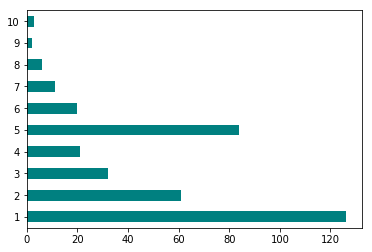

In [14]:
#Setup Training Data
team_counts = data_dict['TeamSpellings'].groupby('TeamID')['TeamNameSpelling'].count().reset_index()
team_counts.columns = ['TeamID', 'TeamSpellingCount']
team_counts['TeamSpellingCount'].value_counts().sort_index().plot(kind='barh', color='teal');


new_df = pd.merge(new_df, team_counts, how='left', left_on='Team1', right_on='TeamID')
new_df = new_df.drop(['TeamID'], axis=1)
new_df = pd.merge(new_df, team_counts, how='left', left_on='Team2', right_on='TeamID')
new_df = new_df.drop(['TeamID'], axis=1)

print(sub.head())
sub = pd.merge(sub, team_counts, how='left', left_on='Team1', right_on='TeamID')
sub = sub.drop(['TeamID'], axis=1)
sub = pd.merge(sub, team_counts, how='left', left_on='Team2', right_on='TeamID')
sub = sub.drop(['TeamID'], axis=1)

new_df = new_df.drop(['Season', 'Team1', 'Team2'], axis=1)
sub = sub.drop(['Pred', 'Season', 'Team1', 'Team2', 'TeamID_x', 'TeamID_y', 'WTeamID_x', 'WTeamID_y', 'LTeamID_x', 'LTeamID_y'], axis=1)
sub.columns = ['ID', 'Seed_1', 'Seed_2', 'WScore_1', 'LScore_1', 'LScore_2', 'WScore_2', 'seed_diff', 'TeamSpellingCount_x', 'TeamSpellingCount_y']
sub = sub[['ID', 'Seed_1', 'Seed_2', 'seed_diff', 'WScore_1', 'LScore_1', 'LScore_2', 'WScore_2', 'TeamSpellingCount_x', 'TeamSpellingCount_y']]
new_df = new_df.fillna(0)
sub = sub.fillna(0)


In [15]:
X = new_df.drop(['target'], axis=1)
y = new_df['target']
X_test = sub.drop(['ID'], axis=1)

In [16]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [17]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y.values[train_index], y.values[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid)[:, 1].reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, learning_rate=0.1, loss_function='Logloss',  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)
            y_pred = model.predict_proba(X_test)
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(log_loss(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [18]:
X1 = X.copy()
X_test1 = X_test.copy()

In [19]:
scaler = StandardScaler()
X1[['WScore_1', 'LScore_1', 'LScore_2', 'WScore_2']] = scaler.fit_transform(X1[['WScore_1', 'LScore_1', 'LScore_2', 'WScore_2']])
X_test1[['WScore_1', 'LScore_1', 'LScore_2', 'WScore_2']] = scaler.transform(X_test1[['WScore_1', 'LScore_1', 'LScore_2', 'WScore_2']])

In [20]:
%%time
model = linear_model.LogisticRegression(C=0.0001)
oof_lr, prediction_lr, scores = train_model(X1, X_test1, y, params=None, folds=folds, model_type='sklearn', model=model)

Fold 0 started at Mon Mar  4 20:24:28 2019


/Users/wildcat/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 started at Mon Mar  4 20:24:29 2019
Fold 2 started at Mon Mar  4 20:24:29 2019
Fold 3 started at Mon Mar  4 20:24:29 2019
Fold 4 started at Mon Mar  4 20:24:29 2019
CV mean score: 0.5316, std: 0.0185.
CPU times: user 145 ms, sys: 13.3 ms, total: 158 ms
Wall time: 549 ms


/Users/wildcat/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wildcat/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wildcat/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wildcat/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [ ]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 5,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 4}
oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)